# Animations with Matplotlib

This notebook shows how to use the `FuncAnimation` function from the `matplotlib.animation` module to create animated plots. 

## Animation Basics

Before we dive into more complex example. it is helpful to understand the basics of matplotlib animation.

Let's define 3 positions and we will create an animation of a point moving between them.

In [116]:
points = [(0.1, 0.5), (0.5, 0.5), (0.9, 0.5)]

Then we use the `FuncAnimation` class which makes an animation by repeatedly calling a function and saving the output as a frame in the animation.

In [117]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

We need to define a function that takes the frame number and generates a plot from it. Here we define a function `animation` that takes the frame index and creates a plot from the point at the same index in the `points` list. So at frame 0, it will display the first point, frame 1 the second point and so on.

In [118]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)

def animate(i):
    ax.clear()
    # Get the point from the points list at index i
    point = points[i]
    # Plot that point using the x and y coordinates
    ax.plot(point[0], point[1], color='green', 
            label='original', marker='o')
    # Set the x and y axis to display a fixed range
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
ani = FuncAnimation(fig, animate, frames=len(points),
                    interval=500, repeat=False)
plt.close()

The animation is now contained in the `ani` object. We can call `save()` and save the result as an animated GIF. We need to specify a `writer` that supports the output format.

In [119]:
from matplotlib.animation import PillowWriter
# Save the animation as an animated GIF
ani.save("simple_animation.gif", dpi=300,
         writer=PillowWriter(fps=1))

<img src='simple_animation.gif' width='250'/>

We can also use the `to_jshtml()` function to create an HTML representation of the animation and display in a Jupyter notebook.

In [120]:
from IPython.display import HTML
HTML(ani.to_jshtml())

## Animating Plots

Now that you understand the basics, it's time to apply this technique to animate plots. I will show 2 different approaches for animating matplotlib plots. I find it very helpful in visualizing iterative algorithms. We will take examples of two popular geometry simplification algorithms and visualize how they work.

1. Visvalingam and Whyatt algorithm
2. Douglas-Peucker algorithm

Let's take a line segment defined by a list of (x,y) coordinates as below.

In [121]:
point_list = [(0,3), (1,0), (2,1), (3, 2), (5, 3),
              (7,4), (8,4), (10,3), (11,1), (12,1),
              (15,2), (17, 3), (18, 3), (20, 2)]

We will use the `shapely` library to create a `LineString` object and plot it.

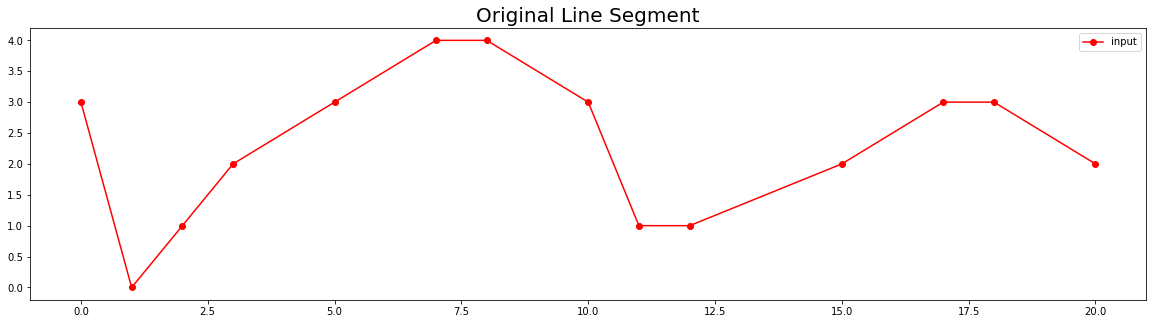

In [122]:
import matplotlib.pyplot as plt
from shapely.geometry import LineString

original = LineString(point_list)
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(20,5)
ax.plot(*original.xy, color='red', 
        label='input', marker='o')
ax.set_title('Original Line Segment', fontsize=20)
ax.legend()
plt.savefig('line.png', bbox_inches='tight', dpi=300)
plt.show()

### Visualizing Visvalingam and Whyatt Algorithm

This algorithm simplifies a line segment by successively removing vertices till the required number of vertices remain. It calculates the areas of triangle formed by three consecutive points and then removes the vertex with the smallest area. [Learn more](https://en.wikipedia.org/wiki/Visvalingam%E2%80%93Whyatt_algorithm).

Below is a python implementation of this algorithm. We use the `shapely` library to calculate polygon areas. This implementation uses a recursive approach to achieve the result.

In [123]:
import math
from shapely.geometry import Polygon

def visvalingam_whyatt_recursive(point_list, required_points):
    # Copy the original list since we will be modifying it
    points = point_list.copy()
    
    if len(points) == required_points:
        return points
    
    # Calculate traingle areas of each point
    areas = []
    for index, point in enumerate(points):
        if index == 0 or index == len(points)-1:
            areas.append(math.inf)
        else:
            p1 = points[index-1]
            p2 = point
            p3 = points[index+1]
            polygon = Polygon([p1, p2, p3])
            areas.append(polygon.area)
    min_area = min(areas)
    remove_index = areas.index(min_area)
    # Remove the vertex with smallest area
    points.pop(remove_index)
    if len(points) == required_points:
        return points
    else:
        # Call the function recursively with updated point list
        return visvalingam_whyatt_recursive(
            points, required_points)

Let's test the function and simplify the line to retain only 50% of the original vertices.

In [124]:
required_points = int(len(point_list)/2)
simplified_list = visvalingam_whyatt_recursive(
    point_list, required_points)
print('n={}'.format(required_points))
print('original={}'.format(point_list))
print('result={}'.format(simplified_list))

n=7
original=[(0, 3), (1, 0), (2, 1), (3, 2), (5, 3), (7, 4), (8, 4), (10, 3), (11, 1), (12, 1), (15, 2), (17, 3), (18, 3), (20, 2)]
result=[(0, 3), (1, 0), (7, 4), (10, 3), (11, 1), (18, 3), (20, 2)]


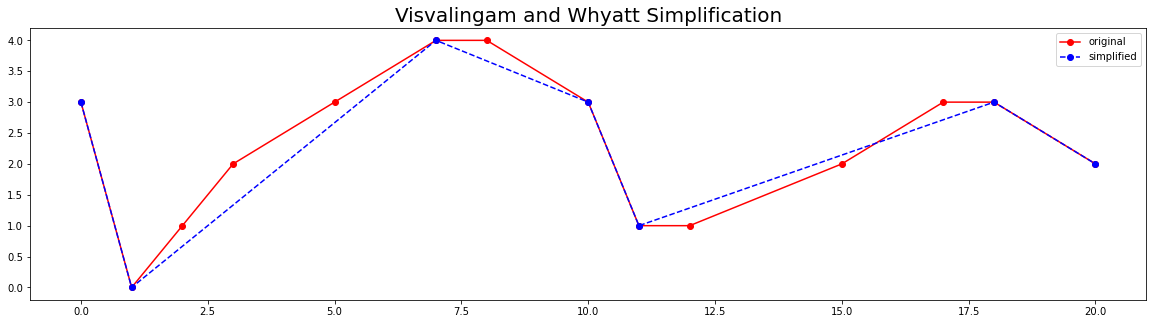

In [125]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(20,5)

original = LineString(point_list)
simplified = LineString(simplified_list)
ax.plot(*original.xy, color='red',
        label='original', marker='o')
ax.plot(*simplified.xy, color='blue',
        linestyle='dashed', label='simplified', marker='o')
ax.set_title('Visvalingam and Whyatt Simplification',
             fontsize=20)
ax.legend()
plt.savefig('visvalingam_whyatt.png',
            bbox_inches='tight', dpi=300)
plt.show()

### Animating the Algorithm

This algorithm removes 1 point at a time. We can visualize how the algorithm works by plotting the results of simplifying the original segment with successively smaller number of points. The `animate()` function gets input as the frame number `i` and we use it to calculate how many points to retain in each iteration. The resulting animation shows how the algorithm chooses the vertex with the smallest area first and removes it - continuing to do the same till only the start and end points remain.

In [126]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(20,5)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

def animate(i):
    ax.clear()
    simplified_list = visvalingam_whyatt_recursive(
        point_list, len(point_list)-i)
    original = LineString(point_list)
    simplified = LineString(simplified_list)
    ax.plot(*original.xy, color='red',
            label='original', marker='o')
    ax.plot(*simplified.xy, color='blue',
            linestyle='dashed', label='simplified', marker='o')
    ax.set_title(
        'Visvalingam and Whyatt Algorithm - '\
        'Eliminated {} Points'.format(i), fontsize=20) 
    ax.legend()

ani = FuncAnimation(fig, animate, frames=len(point_list)-1, 
                    interval=500, repeat=False)
plt.close()

In [127]:
from matplotlib.animation import PillowWriter
# Save the animation as an animated GIF
ani.save("visvalingam_whyatt.gif",
         dpi=300, writer=PillowWriter(fps=2))

<img src='Visvalingam_whyatt.gif'/>

### Visualizing Douglas-Peucker Algorithm

The Douglas-Peucker algorithm successively removes vertices from a segment using the distance between the original segment and simplified segment. It removes points whose distance is less than the specified threshold **e** [Learn more](https://en.wikipedia.org/wiki/Ramer%E2%80%93Douglas%E2%80%93Peucker_algorithm).

Below is a python implementation of this algorithm. We use the `shapely` library to calculate distance between a point and a line segment. This implementation uses a recursive approach to achieve the result. The implementation is adapted from https://github.com/fhirschmann/rdp

In [128]:
from shapely.geometry import Point, LineString

def douglas_peuker_recursive(point_list, e):
    dmax = 0
    index = -1
  
    for i in range(1, len(point_list)):
        point = Point(point_list[i])
        line = LineString([point_list[0], point_list[-1]])
        d = point.distance(line)
        if d > dmax:
            index = i
            dmax = d
    if dmax > e:
        r1 = douglas_peuker_recursive(point_list[:index+1], e)
        r2 = douglas_peuker_recursive(point_list[index:], e)
        return r1[:-1] + r2
    else:
        return [point_list[0], point_list[-1]]
e = 1
simplified_list = douglas_peuker_recursive(point_list, e)
print('e={}'.format(e))
print('original={}'.format(point_list))
print('result={}'.format(simplified))

e=1
original=[(0, 3), (1, 0), (2, 1), (3, 2), (5, 3), (7, 4), (8, 4), (10, 3), (11, 1), (12, 1), (15, 2), (17, 3), (18, 3), (20, 2)]
result=LINESTRING (0 3, 1 0, 7 4, 10 3, 11 1, 18 3, 20 2)


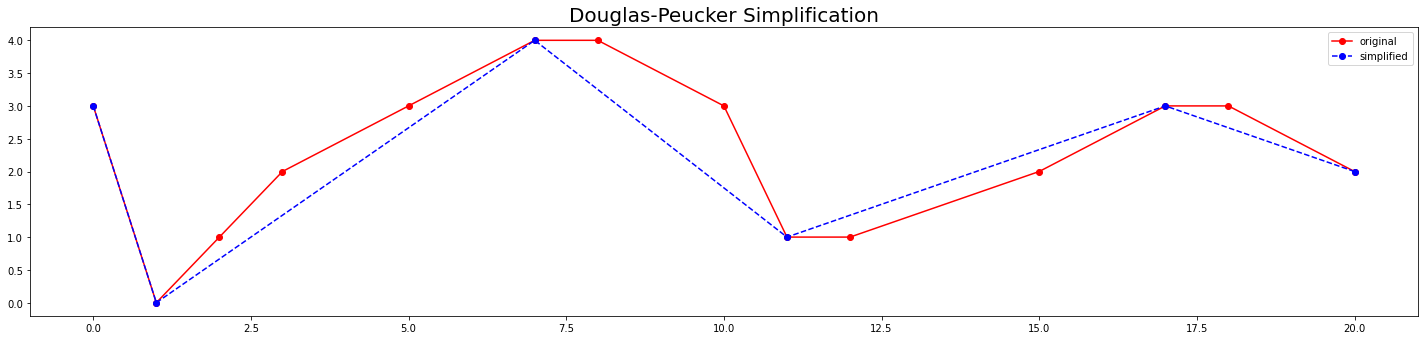

In [129]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(20,5)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

original = LineString(point_list)
simplified = LineString(simplified_list)
ax.plot(*original.xy, color='red',
        label='original', marker='o')
ax.plot(*simplified.xy, color='blue', 
        linestyle='dashed', label='simplified', marker='o')
ax.set_title('Douglas-Peucker Simplification', fontsize=20)
ax.legend()
plt.savefig('douglas_peucker.png', 
            bbox_inches='tight', dpi=300)
plt.show()

### Animating the Algorithm

The Douglas-Peucker algorithm is harder to visualize because each step is done recursively and you need to capture the result of it and plot it. Here I present another strategy to animate each step. We can capture the intermediate results in a separate list and use that list with the `animate()` function. To capture the output of each invocation of the function, we can use a decorator. Since our function is already defined, we can directly call the `track` function instead of the `@track` syntax for decorating the `douglas_peuker_recursive()` function.

Remember that the recursive function may be called multiple times till it before it meets the condition to actually remove a point. So we save the input and output both to our temporary list.

In [130]:
global steps_list
steps_list = []

def track(func):
    def inner(*args, **kwargs):
        global steps_list
        # Save the input point list, and an empty list
        steps_list.append((args[0], []))
        output = func(*args, **kwargs)
        # Save the input point list and simplified point list
        steps_list.append((args[0], output))
        return output
    return inner

douglas_peuker_recursive = track(douglas_peuker_recursive)

In [131]:
simplified_list = douglas_peuker_recursive(point_list, e)

We have now captured each step of the algorithm in the `steps_list`. We can now write an animation function to display each step from it.

In [132]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(20,5)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

def animate(frame):
    ax.clear()
    part, result = steps_list[frame]
    original = LineString(point_list)
    ax.plot(*original.xy, color='red',
            label='original', marker='o')
    if result:
        simplified = LineString(result)
        ax.plot(*simplified.xy, color='blue',
                label='simplified', marker='o')
    elif frame > 0:
        part = LineString(part)
        ax.plot(*part.xy, color='yellow',
                linestyle='dashed', label='part', marker='x')

    ax.set_title('Douglas-Peucker - Step {}'.format(frame),
                 fontsize=20) 
    ax.legend()
ani = FuncAnimation(fig, animate, frames=len(steps_list),
                    interval=500, repeat=False)
plt.close()

In [133]:
from matplotlib.animation import PillowWriter
# Save the animation as an animated GIF
ani.save("douglas_peucker.gif",
         dpi=300, writer=PillowWriter(fps=1))

<img src='douglas_peucker.gif'/>